In [1]:
import pandas as pd
import re
from ipywidgets import interact, interactive, fixed, VBox, HBox, widgets
from IPython.display import display, HTML

# 파일 경로 (사용자님 경로로 설정)
file_path = "C:\\Users\\셜록\\Downloads\\TB_RECIPE_SEARCH_241226.csv"

# CSV 파일 불러오기
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    # 'utf-8'로 실패하면 'cp949' (혹은 'euc-kr') 시도
    df = pd.read_csv(file_path, encoding='cp949')

# 필요한 열의 결측값 처리 (문자열로 대체)
df['CKG_MTRL_CN'] = df['CKG_MTRL_CN'].fillna('')
df['CKG_STA_ACTO_NM'] = df['CKG_STA_ACTO_NM'].fillna('선택 안함')
df['CKG_KND_ACTO_NM'] = df['CKG_KND_ACTO_NM'].fillna('선택 안함')

# 레시피 데이터 확인
print(f"총 레시피 수: {len(df)}")

총 레시피 수: 23192


In [4]:
# --- 재료 추출 함수 정의 (핵심 로직) ---
def extract_pure_ingredients(material_string):
    """
    [재료] 두부 1/2모| 당근 1/2개... 에서 '두부', '당근' 등 순수 재료명만 추출
    """
    if pd.isna(material_string) or not isinstance(material_string, str):
        return []

    # 1. '[재료]' 또는 양쪽 대괄호([ ]) 제거
    material_string = material_string.replace('[재료]', '').strip()
    
    # 2. '|'를 기준으로 개별 재료 항목 분리
    items = material_string.split('|')
    
    pure_ingredients = []
    
    # 3. 각 재료 항목에서 수량/단위 정보 제거
    # 제거할 패턴: 숫자, 분수, 단위(개, 컵, g, ml, t, T, 스푼, 적당히, 약간, 조금, ...)
    # 패턴: 숫자와 숫자에 연결된 모든 문자열, 또는 특정 단위 문자열
    unit_pattern = r'\s*[\d\.\/\(\)]+\s*[^\s]*|T|t|스푼|개|마리|모|줄|쪽|컵|조각|덩이|줌|포기|장|통|술|숟가락|kg|g|ml|적당량|약간|조금|씩|정도|대'
    
    for item in items:
        # 공백 제거
        item = item.strip()
        if not item:
            continue
            
        # 4. 재료명만 남기기 위해 패턴 제거
        pure_name = re.sub(unit_pattern, '', item, flags=re.IGNORECASE)
        
        # 5. 특수문자나 괄호가 남아있을 경우 제거
        pure_name = re.sub(r'[^\w\s]', '', pure_name).strip() 
        
        # 6. 최종적으로 남은 이름이 한 글자 이상일 경우에만 추가
        if len(pure_name) > 1:
            pure_ingredients.append(pure_name)
            
    return pure_ingredients

# 'CKG_MTRL_CN' 열에 함수 적용하여 새로운 열 생성
df['Extracted_Materials'] = df['CKG_MTRL_CN'].apply(extract_pure_ingredients)

# 추출 결과 확인
print("\n[CKG_MTRL_CN] 추출 예시:")
for i in range(3):
    print(f"원본: {df['CKG_MTRL_CN'].iloc[i]} -> 추출: {df['Extracted_Materials'].iloc[i]}")

# 사용하지 않는 결측값 채우기
df['CKG_STA_ACTO_NM'] = df['CKG_STA_ACTO_NM'].fillna('미분류')
df['CKG_KND_ACTO_NM'] = df['CKG_KND_ACTO_NM'].fillna('미분류')
df['CKG_TIME_NM'] = df['CKG_TIME_NM'].fillna('미상')


[CKG_MTRL_CN] 추출 예시:
원본: [재료] 떡국떡400g| 다진소고기100g| 멸치육수800ml| 대파1/3대| 계란2개| 참기름1T| 국간장1T| 참기름1/2T| 다진마늘1t| 소금| 김가루약간 -> 추출: ['떡국떡', '다진소고기', '멸치육수', '계란', '참기름', '국간', '참기름', '다진마늘', '소금', '김가루']
원본: [재료] 돼지고기 수육용삼겹살500g| 된장1.5큰술| 술4큰술| 홍어무침| 무생채| 콩나물무침 -> 추출: ['돼지고기 수육용삼겹살', '홍어무침', '무생채', '콩나물무침']
원본: [재료] 돼지등뼈1.5kg| 양파1/2개| 감자1개| 대파1대| 알배기배추1/2개| 청양고추2개| 깻잎10~15장 [양념] 된장2T| 고추장2T| 다진마늘1T| 간장3T| 고춧가루3T| 액젓3T| 다진생강1t| 다시다1t| 들깨가루3T -> 추출: ['돼지등뼈', '양파', '감자', '알배기배추', '청양고추', '깻잎 양념 된', '고추', '다진마늘', '고춧가루', '액젓', '다진생강', '다시다', '들깨가루']



✅ 상위 50개 최다 사용 재료:
설탕       6302
소금       6249
양파       5999
참기름      5951
다진마늘     5144
고춧가루     3726
후추       3573
계란       2646
청양고추     2587
당근       2447
식용유      2413
진간       2367
식초       2292
올리고당     2113
마늘       2012
고추       1952
다진 마늘    1830
굴소스      1524
국간       1498
참치액      1348
홍고추      1299
두부       1278
들기름      1193
감자       1153
오이       1086
우유        974
버터        920
깨소금       917
멸치액젓      915
애호박       912
달걀        897
마요네즈      852
매실액       833
양배추       793
레몬즙       784
매실청       776
올리브오일     749
부추        733
후춧가루      703
물엿        698
고추가루      648
깻잎        641
부침가루      639
미림        596
표고버섯      569
콩나물       563
팽이버섯      526
새우젓       524
액젓        501
생강        499
Name: count, dtype: int64


C:\Users\셜록\AppData\Local\Temp\ipykernel_27020\3732171325.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_materials.index, y=top_materials.values, palette='viridis')


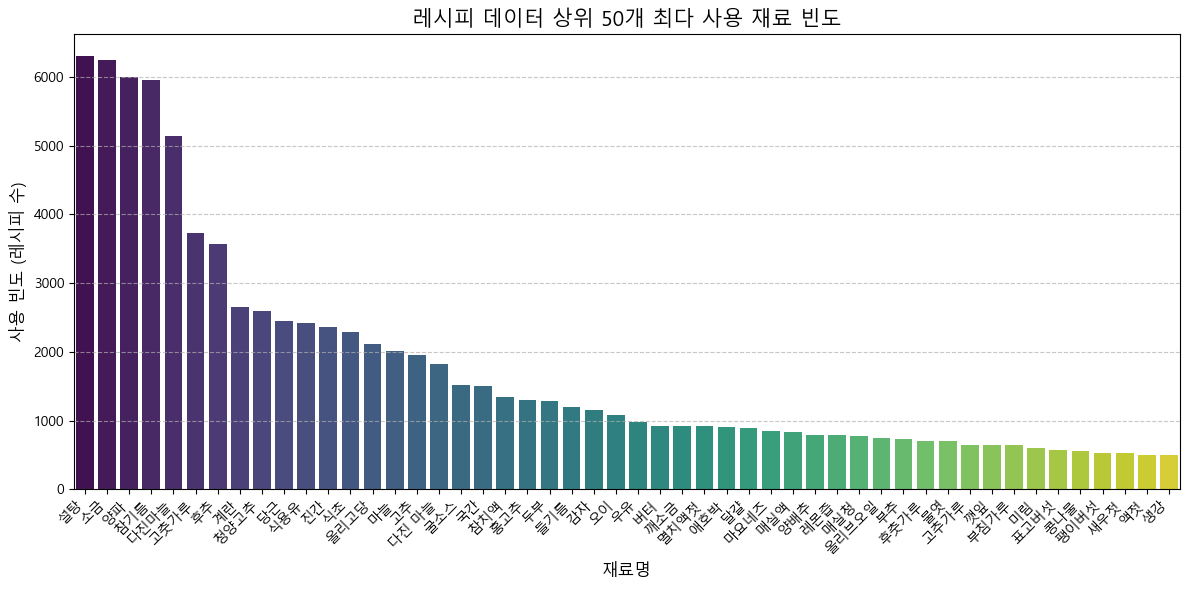

In [11]:
# --- 최다 사용 재료 분석 및 시각화 ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
# 모든 레시피에서 추출된 재료 목록을 하나로 합치기 (Flat List)
all_materials = [material for sublist in df['Extracted_Materials'] for material in sublist]

# 재료별 빈도 계산
material_counts = pd.Series(all_materials).value_counts()

# 너무 빈도가 낮은 재료(노이즈일 가능성) 제거 (예: 50회 미만)
# noise_threshold = 50 
# material_counts = material_counts[material_counts >= noise_threshold]

# 상위 20개 재료 선택
top_n = 50
top_materials = material_counts.head(top_n)

print(f"\n✅ 상위 {top_n}개 최다 사용 재료:")
print(top_materials)

# 시각화: 최다 사용 재료
plt.figure(figsize=(12, 6))
sns.barplot(x=top_materials.index, y=top_materials.values, palette='viridis')
plt.title(f'레시피 데이터 상위 {top_n}개 최다 사용 재료 빈도', fontsize=15)
plt.xlabel('재료명', fontsize=12)
plt.ylabel('사용 빈도 (레시피 수)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


✅ 상위 50개 최다 사용 재료 목록 (일부):
설탕      6302
소금      6249
양파      5999
참기름     5951
다진마늘    5144
고춧가루    3726
후추      3573
계란      2646
청양고추    2587
당근      2447
Name: count, dtype: int64


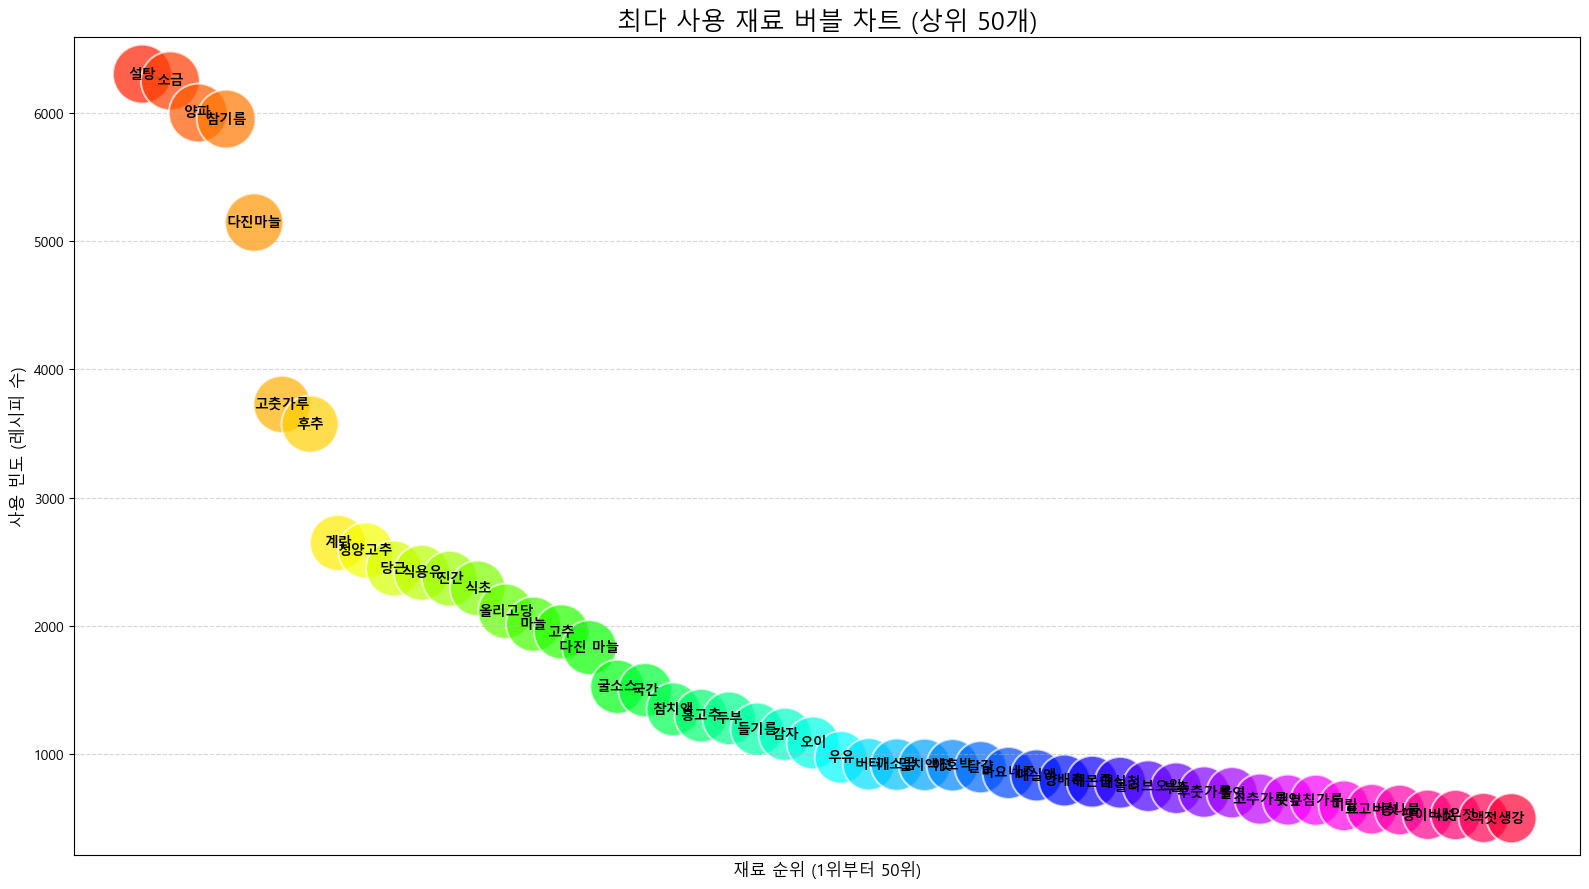

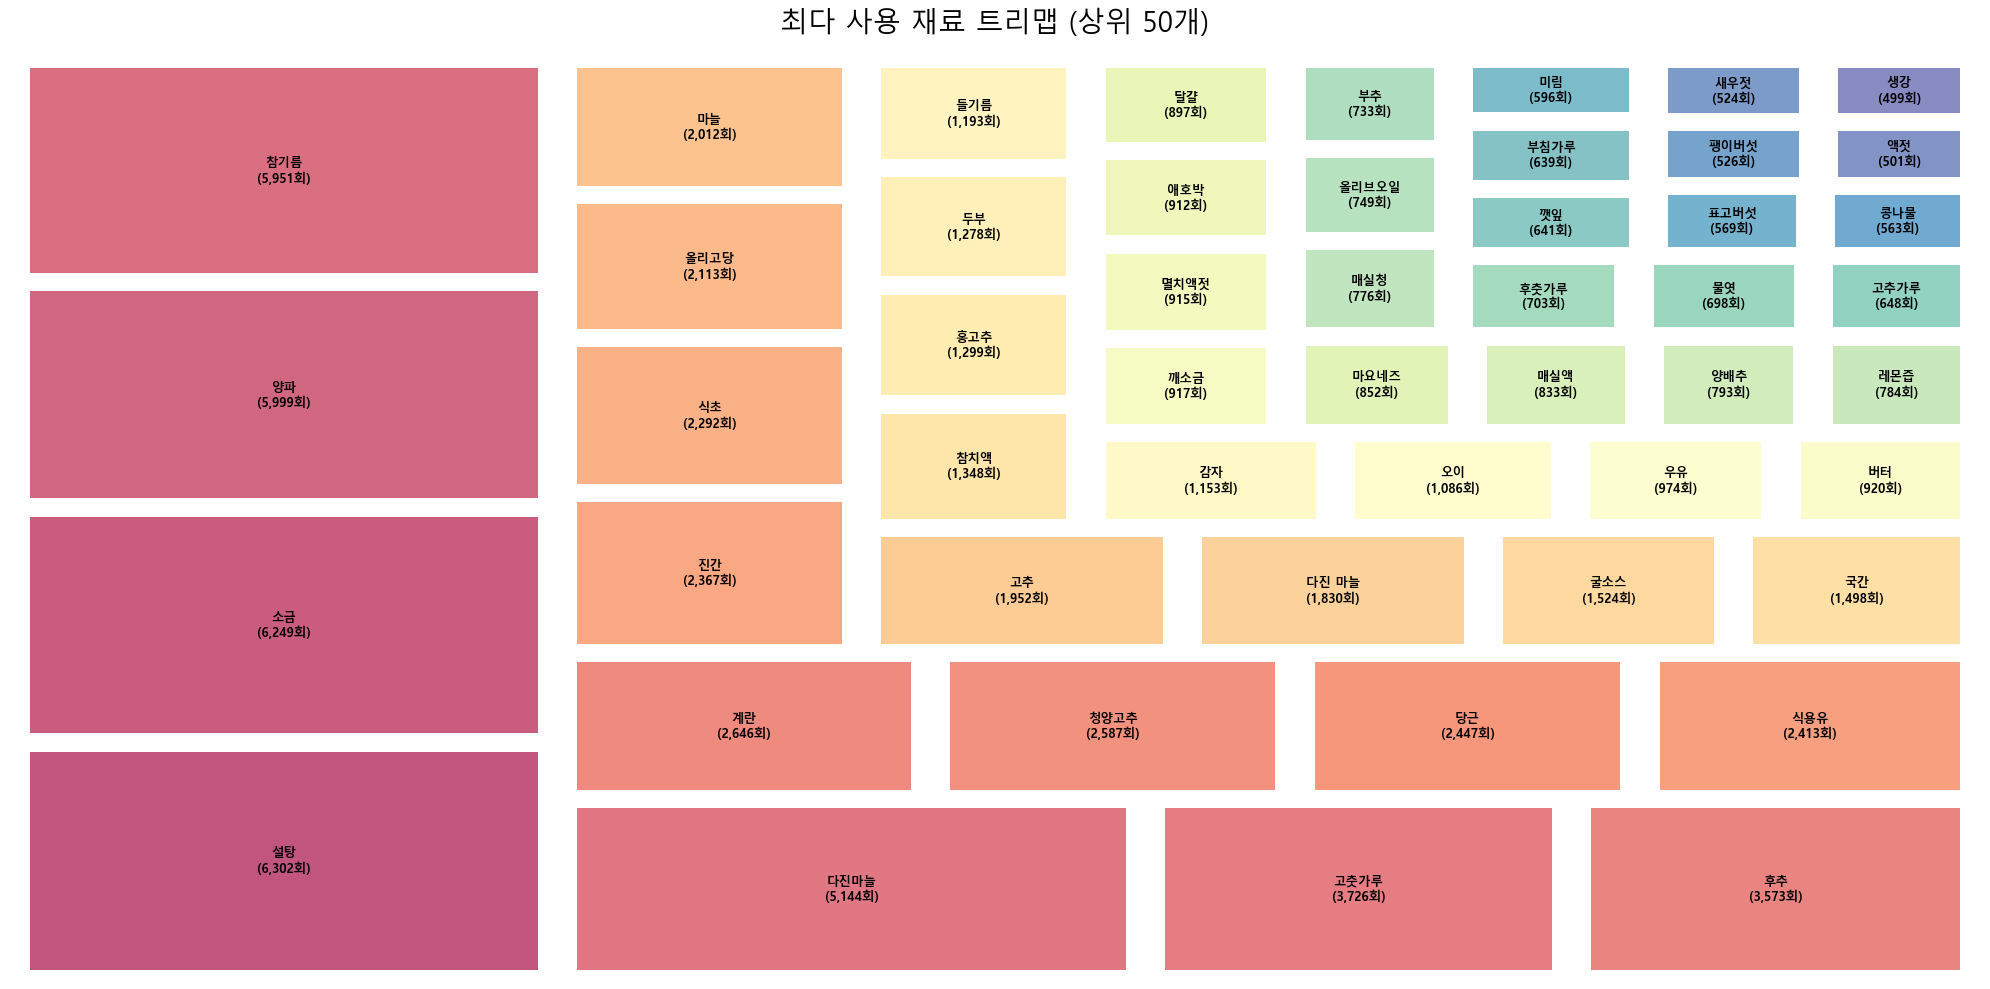

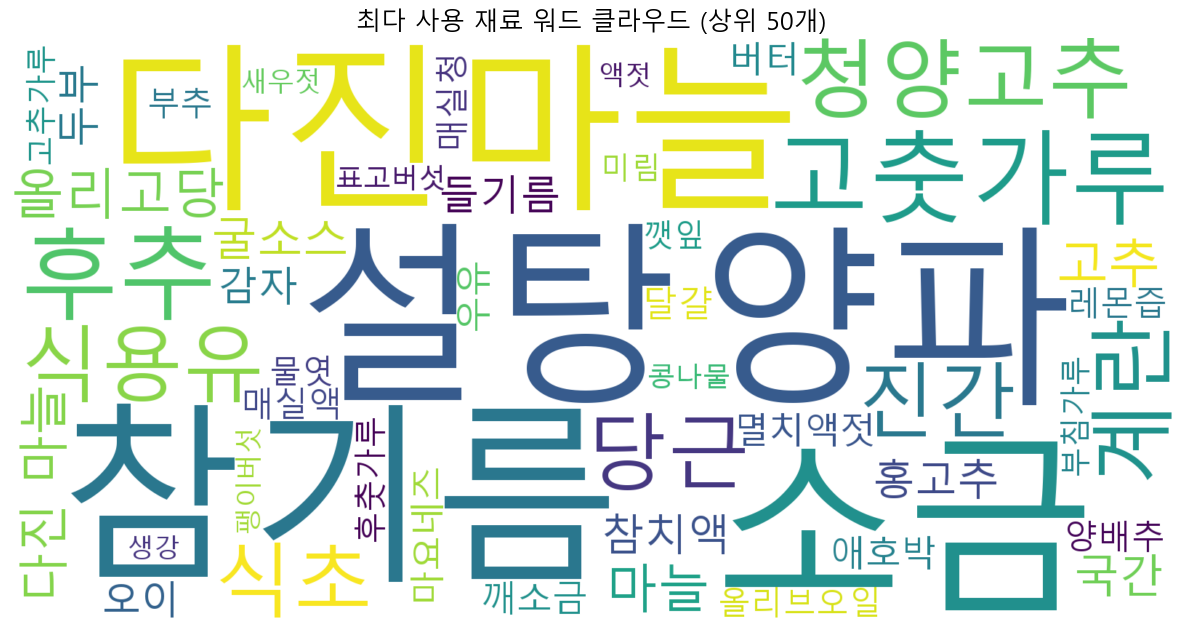

In [12]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify # 트리맵 라이브러리
from wordcloud import WordCloud
import numpy as np

# 한글 폰트 설정 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

# --- 분석 범위 변경: 상위 50개 재료 선택 ---

# 이전 코드에서 계산된 material_counts 데이터 (모든 재료 빈도)를 사용합니다.
# material_counts = pd.Series(all_materials).value_counts() 가 실행되었다고 가정합니다.

top_n = 50
# 상위 50개 재료 선택
top_materials = material_counts.head(top_n)

print(f"\n✅ 상위 {top_n}개 최다 사용 재료 목록 (일부):")
print(top_materials.head(10)) # 상위 10개만 미리보기


# --- 📊 버블 차트 시각화 (Bubble Chart) ---

# 버블 크기 결정 및 스케일링
counts = top_materials.values
# 크기 스케일링 (로그 변환 후 조정)
sizes = (np.log1p(counts) * 200) + 50

plt.figure(figsize=(16, 9))
colors = sns.color_palette('hsv', len(top_materials))

plt.scatter(
    x=range(len(top_materials)), 
    y=counts,                    
    s=sizes,                     
    c=colors,                    
    alpha=0.7,
    edgecolors='w',
    linewidth=1.5
)

# 주요 재료(상위 10개)만 라벨 표시하여 차트 혼잡 방지
for i in range(min(50, len(top_materials))):
    txt = top_materials.index[i]
    plt.annotate(
        txt, 
        (i, counts[i]), 
        ha='center', va='center', fontsize=10, 
        fontweight='bold', color='black'
    )

plt.title(f'최다 사용 재료 버블 차트 (상위 {top_n}개)', fontsize=18)
plt.xlabel('재료 순위 (1위부터 50위)', fontsize=12)
plt.ylabel('사용 빈도 (레시피 수)', fontsize=12)
plt.xticks([]) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------------------------------------

## 🌳 트리맵 시각화 (Treemap)

# 트리맵에 사용할 값과 라벨 준비
sizes = top_materials.values
labels = [f'{name}\n({count:,}회)' for name, count in top_materials.items()]

plt.figure(figsize=(20, 10))

# Treemap 생성
squarify.plot(
    sizes=sizes,
    label=labels,
    color=sns.color_palette('Spectral', len(top_materials)), # 색상 팔레트
    alpha=0.7,
    pad=True,
    text_kwargs={'fontsize': 9, 'color': 'black', 'fontweight': 'bold'}
)

plt.title(f'최다 사용 재료 트리맵 (상위 {top_n}개)', fontsize=20, pad=20)
plt.axis('off') # 축 정보 숨기기
plt.tight_layout()
plt.show()

# ----------------------------------------------------

## ☁️ 워드 클라우드 시각화 (Word Cloud)

# WordCloud 객체 생성 (상위 50개 재료 사용)
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', 
    background_color='white',
    width=1600,
    height=800,
    max_words=top_n, # 최대 단어 수도 50개로 설정
    prefer_horizontal=0.9
)

wordcloud.generate_from_frequencies(top_materials.to_dict())

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'최다 사용 재료 워드 클라우드 (상위 {top_n}개)', fontsize=18)
plt.axis('off') 
plt.show()

In [ ]:
# --- 🎨 UI 위젯 설정 (기존과 동일) ---
ckg_sta_options = ['선택 안함'] + sorted(df['CKG_STA_ACTO_NM'].unique().tolist())
ckg_knd_options = ['선택 안함'] + sorted(df['CKG_KND_ACTO_NM'].unique().tolist())

material_input = widgets.Text(
    value='',
    placeholder='예: 양파, 당근, 계란 (쉼표로 구분)',
    description='필수 재료:',
    style={'description_width': 'initial', 'font_size': '16px'},
    layout=widgets.Layout(width='65%')
)

ckg_sta_select = widgets.Dropdown(
    options=ckg_sta_options,
    value='선택 안함',
    description='요리 상황:',
    style={'description_width': 'initial', 'font_size': '14px'},
    layout=widgets.Layout(width='30%')
)

ckg_knd_select = widgets.Dropdown(
    options=ckg_knd_options,
    value='선택 안함',
    description='요리 종류:',
    style={'description_width': 'initial', 'font_size': '14px'},
    layout=widgets.Layout(width='30%')
)

search_button = widgets.Button(
    description='✨ 레시피 찾아보기 ✨',
    button_style='info', # 모던한 느낌으로 'info' 스타일 사용
    tooltip='입력한 재료와 조건으로 레시피를 검색합니다.',
    layout=widgets.Layout(width='30%', height='45px', font_weight='bold')
)

output_area = widgets.Output()

# --- 🔎 검색 로직 함수 (재료 목록 및 링크 기능 포함) ---
def search_recipes(materials_str, ckg_sta, ckg_knd):
    input_materials = [m.strip().replace(' ', '') for m in re.split(r'[,| ]', materials_str) if m.strip()]
    
    if not input_materials:
        with output_area:
            output_area.clear_output()
            display(HTML("<h4 style='color: #e74c3c;'>⚠️ 재료를 입력해 주세요!</h4>"))
        return

    filtered_df = df.copy()
    if ckg_sta != '선택 안함':
        filtered_df = filtered_df[filtered_df['CKG_STA_ACTO_NM'] == ckg_sta]
    if ckg_knd != '선택 안함':
        filtered_df = filtered_df[filtered_df['CKG_KND_ACTO_NM'] == ckg_knd]
        
    if filtered_df.empty:
        with output_area:
            output_area.clear_output()
            display(HTML(f"<h4 style='color: #e74c3c;'>😭 선택한 조건에 맞는 레시피가 없습니다.</h4>"))
        return

    def get_matches_and_count(recipe_materials_str):
        if pd.isna(recipe_materials_str) or not recipe_materials_str:
            return 0, []
        
        recipe_materials_list = recipe_materials_str.split('|')
        match_count = 0
        matched_materials = []
        
        for input_mat in input_materials:
            if any(input_mat in mat.replace(' ', '') for mat in recipe_materials_list):
                match_count += 1
                matched_materials.append(input_mat)
                
        return match_count, matched_materials

    match_results = filtered_df['CKG_MTRL_CN'].apply(lambda x: get_matches_and_count(x))
    filtered_df['Match_Count'] = match_results.apply(lambda x: x[0])
    filtered_df['Matched_Materials'] = match_results.apply(lambda x: x[1])

    top_recipes = filtered_df.sort_values(by=['Match_Count', 'INQ_CNT'], ascending=[False, False])
    top_recipes = top_recipes[top_recipes['Match_Count'] > 0]
    
    # RCP_SNO, Matched_Materials 포함
    final_results = top_recipes[['CKG_NM', 'CKG_TIME_NM', 'Match_Count', 'RCP_SNO', 'Matched_Materials']].head(7)
    
    # 5. 결과 출력
    with output_area:
        output_area.clear_output()
        
        if final_results.empty:
            display(HTML(f"<h4 style='color: #e74c3c;'>입력한 재료를 포함하는 레시피를 찾지 못했습니다.</h4>"))
            return

        # 모던하고 예쁜 스타일 적용
        result_title = f"""
        <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-top: 20px;'>
            ✅ 추천 레시피 ({len(final_results)}개)
        </h3>
        <p style='font-size: 14px; color: #7f8c8d;'>
            입력 재료: <b>{', '.join(input_materials)}</b>
        </p>
        """
        display(HTML(result_title))

        # 결과를 보기 좋게 HTML 표로 변환
        html_table = f"""
        <style>
            .recipe-table {{
                width: 100%; border-collapse: collapse; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1); border-radius: 8px; overflow: hidden;
            }}
            .recipe-table th, .recipe-table td {{
                border: 1px solid #ecf0f1; padding: 12px; text-align: left;
            }}
            .recipe-table thead tr {{
                background-color: #3498db; color: white;
            }}
            .recipe-table tbody tr:nth-child(even) {{
                background-color: #f9f9f9;
            }}
            .recipe-table tbody tr:hover {{
                background-color: #eaf2f8; transition: background-color 0.3s;
            }}
            .recipe-link {{
                color: #2980b9; text-decoration: none; font-weight: bold;
            }}
            .recipe-link:hover {{
                text-decoration: underline; color: #1e6293;
            }}
            .match-count {{
                color: #27ae60; font-weight: bold; text-align: center;
            }}
        </style>
        <table class='recipe-table'>
            <thead>
                <tr>
                    <th style='width: 35%;'>레시피 제목 (클릭)</th>
                    <th style='width: 15%; text-align: center;'>소요 시간</th>
                    <th style='width: 15%; text-align: center;'>재료 일치 수</th>
                    <th style='width: 35%;'>일치된 재료</th>
                </tr>
            </thead>
            <tbody>
        """
        for index, row in final_results.iterrows():
            recipe_link = f"<a href='https://www.10000recipe.com/recipe/{row['RCP_SNO']}' target='_blank' class='recipe-link'>{row['CKG_NM']}</a>"
            matched_materials_str = ', '.join(row['Matched_Materials'])
            
            html_table += f"""
            <tr>
                <td>{recipe_link}</td>
                <td style='text-align: center;'>{row['CKG_TIME_NM']}</td>
                <td class='match-count'>{row['Match_Count']}개</td>
                <td>{matched_materials_str}</td>
            </tr>
            """
        html_table += "</tbody></table>"
        
        display(HTML(html_table))


# --- 🔗 이벤트 연결 (기존과 동일) ---
def on_button_click(b):
    search_recipes(material_input.value, ckg_sta_select.value, ckg_knd_select.value)

search_button.on_click(on_button_click)


# --- 🖥️ 메인 UI 레이아웃 구성 ---
# 메인 화면 레이아웃 (VBox 위젯)
input_and_button = HBox([
    material_input,
    search_button
], layout=widgets.Layout(align_items='flex-end', width='100%', justify_content='space-between'))

condition_section = HBox([
    ckg_sta_select, 
    widgets.Label(value="", layout=widgets.Layout(width='5%')), # 간격 조절
    ckg_knd_select
], layout=widgets.Layout(justify_content='center', width='100%'))

main_ui_elements = [
    widgets.HTML("<h2>🍳 레시피 추천 시스템</h2><p>✨ **가지고 계신 재료**를 입력하고, 요리 조건(선택 사항)을 선택하여 레시피를 추천받으세요!</p>"),
    input_and_button,
    condition_section,
    widgets.HTML("<hr style='border: 1px solid #bdc3c7;'>"),
    output_area
]

main_ui = VBox(main_ui_elements, layout=widgets.Layout(padding='20px', border='1px solid #ecf0f1', border_radius='10px', background='white'))

In [ ]:
from ipywidgets import VBox, Button, HTML, Output, Layout
from IPython.display import display, clear_output

# --- 🖥️ 스플래시 스크린 HTML ---
splash_html = """
<style>
    @keyframes fadeIn {
        from { opacity: 0; transform: translateY(30px); }
        to { opacity: 1; transform: translateY(0); }
    }
    .splash-container {
        text-align: center; 
        padding: 80px 40px; 
        background: linear-gradient(135deg, #f0f7ff 0%, #e0e6f0 100%); 
        border-radius: 25px; 
        box-shadow: 0 15px 30px rgba(44, 62, 80, 0.2); 
        width: 90%; 
        max-width: 650px; 
        margin: 80px auto; 
        border: 1px solid #dcdcdc;
    }
    .splash-title {
        font-size: 3.5em; 
        color: #e67e22;
        margin-bottom: 10px;
        text-shadow: 3px 3px 6px rgba(0, 0, 0, 0.15);
        font-weight: 800;
        animation: fadeIn 1s ease-out;
    }
    .splash-subtitle {
        font-size: 1.4em; 
        color: #34495e;
        margin-bottom: 50px;
        font-weight: 300;
        animation: fadeIn 1.5s ease-out;
    }
</style>
<div class="splash-container">
    <div class="splash-title">지운이의 레시피 추천!!!!!!!</div>
    <div class="splash-subtitle">🌟 나만의 맞춤 레시피를 지금 바로 찾아보세요! 👩‍🍳</div>
</div>
"""

# --- 🎯 위젯 기반 화면 전환 ---
# 출력을 관리할 메인 컨테이너
main_container = Output()

# 스플래시 화면 위젯
splash_widget = HTML(splash_html)

# 시작 버튼
start_button = Button(
    description='시작하기',
    button_style='success',
    layout=Layout(width='200px', height='50px'),
    style={'button_color': '#2ecc71', 'font_weight': 'bold', 'font_size': '18px'}
)

# 버튼 클릭 이벤트 핸들러
def on_start_clicked(b):
    with main_container:
        clear_output(wait=True)
        # main_ui 위젯을 여기서 표시
        # main_ui는 이전에 정의된 VBox 위젯이어야 합니다
        display(main_ui)

start_button.on_click(on_start_clicked)

# 초기 화면 구성 (스플래시 + 버튼)
initial_screen = VBox([
    splash_widget,
    start_button
], layout=Layout(align_items='center'))

# 메인 컨테이너에 초기 화면 표시
with main_container:
    display(initial_screen)

# 최종 출력
display(main_container)

Output()